# This Movie Recommendation System consists of two parts: Collaborative Filtering and Content-Based Filtering. Let's begin with the 1st!

# Collaborative Filtering (CF)
- Part 1: Data Merging Process for CF
- Part 2: Memory-based Collaborative Filtering (K-Nearest Neighbors)
- Part 3: Model-based Collaborative Filtering (Single Value Decomposition)

## Part 1: Data Merging Process for CF

In [109]:
# merge 'tmdb_5000_movies.csv','tmdb_5000_credits.csv' and 'movies.csv'
merged_df = pd.merge(tmovies_df, credits_df,on=['title'], how='inner')
merged_df = pd.merge(merged_df, movies_df,on=['title'], how='inner')
merged_df_mask = merged_df[['title', 'genres_y', 'movieId']]
ratings_df = pd.read_csv('ratings.csv')
ratings = pd.merge(merged_df_mask, ratings_df, on = ['movieId'], how = 'inner')
ratings.to_csv("merged_ratings.csv")

## Part 2: Memory-based Collaborative Filtering (K-Nearest Neighbors)

In [25]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from IPython.display import display  

# Load dataset for CF
df1 = pd.read_csv("merged_ratings.csv")

# Drop the "Unnamed: 0" column
df1.drop(columns=["Unnamed: 0"], inplace=True)

# Rename "genres_y" to "genres"
df1.rename(columns={"genres_y": "genres"}, inplace=True)
display(df1) 

# Define rating scale range
rating_min, rating_max = df1['rating'].min(), df1['rating'].max()
print(f"Rating scale: {rating_min} to {rating_max}")
# Print out total number of movies and users
num_movies = df1["movieId"].nunique()
num_users = df1["userId"].nunique()
print(f"Number of unique movies: {num_movies}")
print(f"Number of unique users: {num_users}")

,movieId,title,genres,userId,rating
0,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,10,2.5
1,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,15,3.0
2,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,18,4.0
3,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,21,4.0
4,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,22,3.5
...,...,...,...,...,...
50301,8914,Primer (2004),Drama|Sci-Fi,417,2.5
50302,8914,Primer (2004),Drama|Sci-Fi,474,4.0
50303,8914,Primer (2004),Drama|Sci-Fi,477,5.0
50304,8914,Primer (2004),Drama|Sci-Fi,599,3.0


Rating scale: 0.5 to 5.0
Number of unique movies: 2560
Number of unique users: 610


,counts,average_rating,highest_rating,lowest_rating
userId,,,,
278,2,4.50,5.0,4.0
53,4,5.00,5.0,5.0
397,6,4.08,5.0,3.5
92,6,4.08,5.0,3.5
576,6,2.67,4.5,1.0
120,6,2.83,4.0,2.0
245,6,2.83,4.0,1.0
329,7,2.79,5.0,0.5
472,7,3.50,4.5,1.0


,counts,average_rating,highest_rating,lowest_rating
userId,,,,
414,1181,3.45,5.0,0.5
448,912,2.87,5.0,0.5
599,888,2.75,5.0,0.5
274,723,3.21,5.0,0.5
68,701,3.26,5.0,0.5
249,654,3.68,5.0,0.5
610,652,3.60,5.0,1.0
380,625,3.65,5.0,1.0
474,622,3.49,5.0,0.5


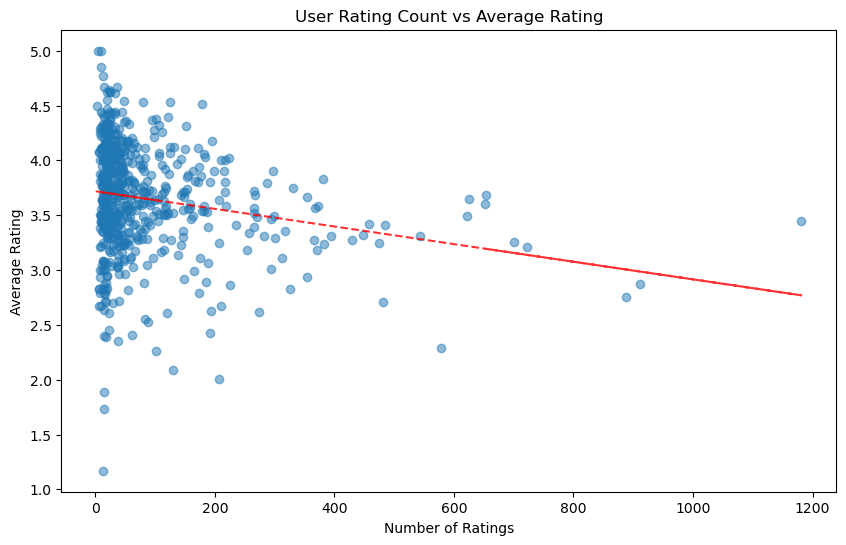

In [69]:
# Get comprehensive rating statistics per user
user_rating_stats = df1.groupby('userId')['rating'].agg(['count', 'mean', 'max', 'min']).round(2)
user_rating_stats.columns = ['counts', 'average_rating', 'highest_rating', 'lowest_rating'] 

# Display top 10 most active & inactive users (rated most)
display(user_rating_stats.sort_values('counts', ascending=True).head(10))
display(user_rating_stats.sort_values('counts', ascending=False).head(10))

# Scatter plot with trend line
plt.figure(figsize=(10, 6))
plt.scatter(user_rating_stats['counts'], user_rating_stats['average_rating'], alpha=0.5)
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.title('User Rating Count vs Average Rating')

# Add trend line
z = np.polyfit(user_rating_stats['counts'], user_rating_stats['average_rating'], 1)
plt.plot(user_rating_stats['counts'], np.poly1d(z)(user_rating_stats['counts']), "r--", alpha=0.8)

plt.show()

In [70]:
# Sort user_1_data by rating from highest to lowest
user_1_data_sorted = user_1_data.sort_values(by="rating", ascending=False)

# Calculate the percentage of rated movies vs unrated movies
total_movies = num_movies  # Total number of movies in the dataset
rated_movies = user_1_data["movieId"].nunique()  # Unique movies rated by user 1
unrated_movies = total_movies - rated_movies  # Unrated movies

rated_percentage = (rated_movies / total_movies) * 100
unrated_percentage = (unrated_movies / total_movies) * 100

# Create a DataFrame for rated vs unrated percentage
rating_distribution = pd.DataFrame({
    "Category": ["Rated Movies", "Unrated Movies"],
    "Count": [rated_movies, unrated_movies],
    "Percentage": [rated_percentage, unrated_percentage]
})

# Display sorted user ratings, rating statistics, and rated/unrated movie percentages
display(user_1_data_sorted)  # Sorted ratings
display(user_1_stats)        # User 1 rating statistics
display(rating_distribution) # Rated vs Unrated movies percentage
# Print total number of movies in the dataset
print(f"User 1: total rated number of movies {rated_movies} out of {total_movies} movies, rated percentage is {rated_percentage}%.")


# Display user 1's most preferred movie genres
# Extract preferred genres based on highest-rated movies
highly_rated_movies = user_1_data_sorted[user_1_data_sorted["rating"] >= 4.0]  # Movies rated 4 or above

# Split genres and count occurrences
from collections import Counter

genre_list = highly_rated_movies["genres"].str.split("|").explode()  # Split genres into individual entries
genre_counts = Counter(genre_list)  # Count occurrences of each genre

# Convert to DataFrame
preferred_genres_df = pd.DataFrame(genre_counts.items(), columns=["Genre", "Count"]).sort_values(by="Count", ascending=False)
display(preferred_genres_df)


,movieId,title,genres,userId,rating
48722,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller,1,5.0
32562,2291,Edward Scissorhands (1990),Drama|Fantasy|Romance,1,5.0
36116,1275,Highlander (1986),Action|Adventure|Fantasy,1,5.0
47819,1282,Fantasia (1940),Animation|Children|Fantasy|Musical,1,5.0
47889,2948,From Russia with Love (1963),Action|Adventure|Thriller,1,5.0
...,...,...,...,...,...
9077,736,Twister (1996),Action|Adventure|Romance|Thriller,1,3.0
7579,1676,Starship Troopers (1997),Action|Sci-Fi,1,3.0
50168,223,Clerks (1994),Comedy,1,3.0
33161,1219,Psycho (1960),Crime|Horror,1,2.0


,Total Rated Movies,Average Rating,Highest Rating,Lowest Rating
rating,106.0,4.32,5.0,2.0


,Category,Count,Percentage
0,Rated Movies,106,4.140625
1,Unrated Movies,2454,95.859375


User 1: total rated number of movies 106 out of 2560 movies, rated percentage is 4.140625%.


,Genre,Count
6,Action,38
11,Comedy,36
3,Drama,32
7,Adventure,31
2,Thriller,21
4,Fantasy,21
0,Crime,16
12,Sci-Fi,14
5,Romance,13
14,War,11


In [71]:
user_movie_matrix = df1.pivot_table(index="userId", columns="title", values="rating").fillna(0)
print(f"Number of Users and Number of Movies: {len(user_movie_matrix.index), len(user_movie_matrix.columns)}")
display(user_movie_matrix)

# Define rating scale range
rating_min, rating_max = df1['rating'].min(), df1['rating'].max()
print(f"Rating scale: {rating_min} to {rating_max}")
# Print out total number of movies and users
num_movies = df1["movieId"].nunique()
num_users = df1["userId"].nunique()
print(f"Number of unique movies: {num_movies}")
print(f"Number of unique users: {num_users}")

Number of Users and Number of Movies: (610, 2558)


title,(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),102 Dalmatians (2000),10th & Wolf (2006),11:14 (2003),12 Angry Men (1957),12 Rounds (2009),12 Years a Slave (2013),127 Hours (2010),...,Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zulu (2013),[REC] (2007),[REC]² (2009),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0


Rating scale: 0.5 to 5.0
Number of unique movies: 2560
Number of unique users: 610



🔹 Step 1: User 1's Ratings Vector (Ratings across different movies) (First 10 Movies)


,movieId,title,genres,rating
0,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller,5.0
1,2291,Edward Scissorhands (1990),Drama|Fantasy|Romance,5.0
2,1275,Highlander (1986),Action|Adventure|Fantasy,5.0
3,1282,Fantasia (1940),Animation|Children|Fantasy|Musical,5.0
4,2948,From Russia with Love (1963),Action|Adventure|Thriller,5.0
5,1517,Austin Powers: International Man of Mystery (1...,Action|Adventure|Comedy,5.0
6,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi,5.0
7,954,Mr. Smith Goes to Washington (1939),Drama,5.0
8,3253,Wayne's World (1992),Comedy,5.0
9,2115,Indiana Jones and the Temple of Doom (1984),Action|Adventure|Fantasy,5.0



🔹 Step 2: Finding Similar Users to the Target User 1


C:\Users\aliso\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,User ID,Cosine Similarity Score
0,57,0.435220
1,597,0.421346
2,202,0.411821
3,469,0.411693
4,19,0.382314



🔹 Step 3: User-Based CF - Recommended Movies:


C:\Users\aliso\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,title,movieId,rating,genres
0,It's a Wonderful Life (1946),953,5.0,Children|Drama|Fantasy|Romance
1,Raging Bull (1980),1228,5.0,Drama
2,Taxi Driver (1976),111,5.0,Crime|Drama|Thriller
3,Glengarry Glen Ross (1992),1095,5.0,Drama
4,Menace II Society (1993),493,5.0,Action|Crime|Drama
5,Tora! Tora! Tora! (1970),3066,5.0,Action|Drama|War
6,Annie Hall (1977),1230,5.0,Comedy|Romance
7,Hoop Dreams (1994),246,5.0,Documentary
8,Casablanca (1942),912,5.0,Drama|Romance
9,"Sex, Lies, and Videotape (1989)",1186,5.0,Drama


C:\Users\aliso\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


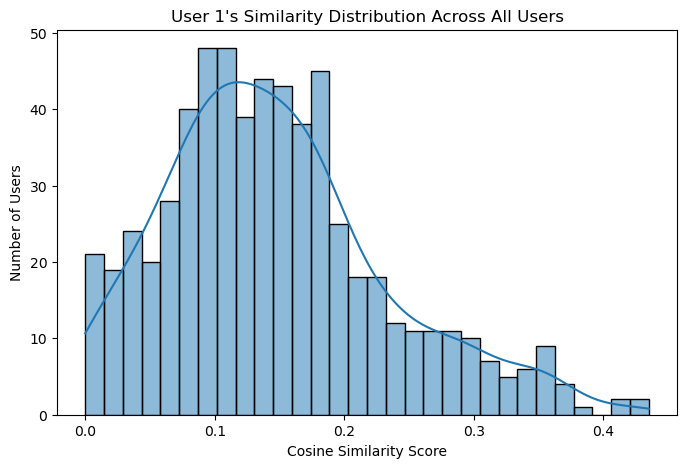

In [72]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Step 1: Compute User-User Similarity Using KNN
knn_user = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10).fit(user_movie_matrix)

# Step 2: Show the ratings given by a specific user
def get_user_rating_vector(user_id):
    user_ratings = df1[df1['userId'] == user_id][['movieId','title', 'genres', 'rating']].sort_values(by='rating', ascending=False).reset_index(drop=True)
    return user_ratings.head(10)  # Show first 10 ratings

# Step 3: Find similar users based on cosine similarity and display similarity scores
def get_similar_users(user_id, top_n=5):
    if user_id not in user_movie_matrix.index:
        print(f"User {user_id} not found in dataset!")
        return pd.DataFrame(columns=["User ID", "Cosine Similarity Score"])
    
    user_idx = user_movie_matrix.index.get_loc(user_id)  # Get user index
    distances, indices = knn_user.kneighbors(
        user_movie_matrix.iloc[user_idx].values.reshape(1, -1), 
        n_neighbors=min(top_n + 1, len(user_movie_matrix))
    )
    
    # Extract similar user IDs (excluding itself)
    similar_users = [user_movie_matrix.index[i] for i in indices.flatten()[1:]]
    
    # Extract similarity scores (cosine similarity = 1 - distance)
    similarity_scores = [1 - distances.flatten()[i] for i in range(1, len(distances.flatten()))]
    
    # Combine into a DataFrame
    similar_users_df = pd.DataFrame({
        "User ID": similar_users,
        "Cosine Similarity Score": similarity_scores
    }).sort_values(by="Cosine Similarity Score", ascending=False)

    return similar_users_df
    # To verify that the users are truly the most similar:#1. Sort and display the top 10 most similar users 
                                                          #2. Plot a histogram of cosine similarity scores across all user


# Step 4: Recommend movies based on similar users
def get_user_based_recommendations(user_id, top_n=10):
    similar_users_df = get_similar_users(user_id, top_n=5)  # Get top 5 similar users
    
    if similar_users_df.empty:
        print("No similar users found.")
        return pd.DataFrame(columns=["movieId", "title", "genres", "rating"])  

    similar_users = similar_users_df["User ID"].tolist()  # Extract user IDs

    # Get movies rated by similar users
    similar_user_ratings = df1[df1["userId"].isin(similar_users)]

    # Ensure we don’t recommend movies User 1 has already seen
    user_rated_movies = set(df1[df1["userId"] == user_id]["title"])
    unseen_movies = similar_user_ratings[~similar_user_ratings["title"].isin(user_rated_movies)]

    if unseen_movies.empty:
        print("No new movies to recommend.")
        return pd.DataFrame(columns=["movieId", "title", "genres", "rating"])

    # Aggregate average rating for each movie  
    recommended_movies = unseen_movies.groupby(["title", "movieId"]).agg(
        {"rating": "mean", "genres": "first"}).reset_index()

    # Sort by highest average rating
    recommended_movies = recommended_movies.sort_values(by="rating", ascending=False)

    # Reset index  
    recommended_movies.reset_index(drop=True, inplace=True)
    return recommended_movies.head(top_n)


# Step 5: Verify that the users are truly the most similar
def plot_similarity_histogram(user_id):
    """Plot a histogram of similarity scores across all users"""
    all_distances, all_indices = knn_user.kneighbors(
        user_movie_matrix.iloc[user_movie_matrix.index.get_loc(user_id)].values.reshape(1, -1),
        n_neighbors=len(user_movie_matrix)
    )
    
    all_similarity_scores = [1 - all_distances.flatten()[i] for i in range(1, len(all_distances.flatten()))]
    
    plt.figure(figsize=(8, 5))
    sns.histplot(all_similarity_scores, bins=30, kde=True)
    plt.xlabel("Cosine Similarity Score")
    plt.ylabel("Number of Users")
    plt.title(f"User {user_id}'s Similarity Distribution Across All Users")
    plt.show()


# Example Usage (Random option)
example_user = 1

## Step 1: Show the Target User's Rating Vector
print(f"\n🔹 Step 1: User {example_user}'s Ratings Vector (Ratings across different movies) (First 10 Movies)")
user1_rating_vector = get_user_rating_vector(example_user)
display(user1_rating_vector)

## Step 2: Compute & Display Similar Users
print(f"\n🔹 Step 2: Finding Similar Users to the Target User {example_user}")

similar_users_df = get_similar_users(example_user, top_n=5)
display(similar_users_df)

## Step 3: Recommend Movies
print("\n🔹 Step 3: User-Based CF - Recommended Movies:")
user_based_recommendations = get_user_based_recommendations(example_user, top_n=10)
display(user_based_recommendations)

## Step 4: Visualize the Target User's Similarity Distribution
plot_similarity_histogram(example_user)


In [73]:
# Extract genres from the recommended movies for User 1
recommended_genres = user_1_data_sorted["genres"].str.split("|").explode()

# Count the occurrences of each genre
genre_counts = recommended_genres.value_counts()

# Convert to DataFrame for better readability
preferred_genres_df = pd.DataFrame({
    "Genre": genre_counts.index,
    "Count": genre_counts.values
})

# Display the most preferred genres for User 1 based on recommended movies
display(preferred_genres_df)


,Genre,Count
0,Action,45
1,Comedy,41
2,Adventure,37
3,Drama,34
4,Thriller,28
5,Fantasy,24
6,Crime,19
7,Sci-Fi,17
8,Romance,14
9,Children,12


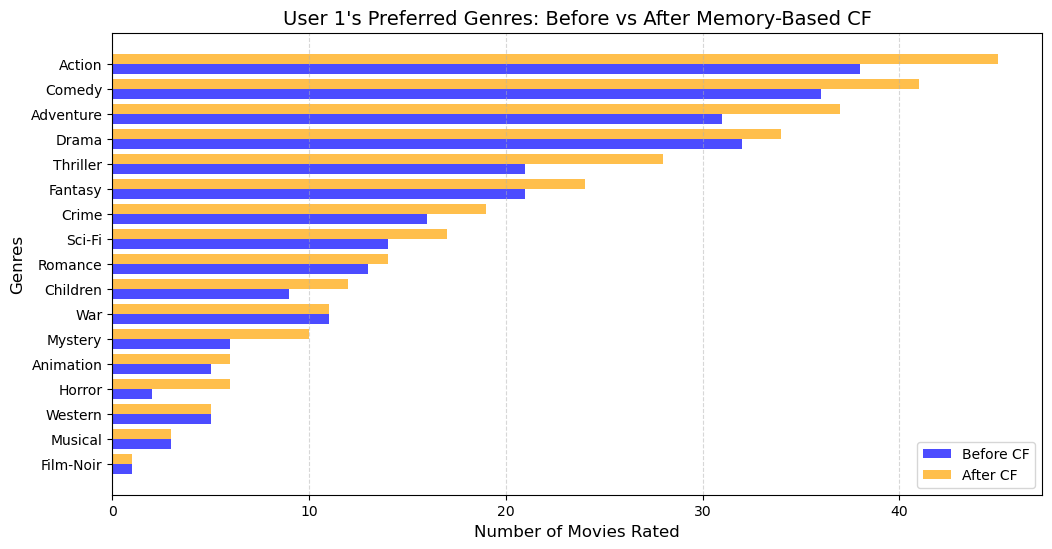

In [116]:
# Extract genres before applying CF
before_genres = user_1_data_sorted[user_1_data_sorted["rating"] >= 4.0]["genres"].str.split("|").explode()
before_genre_counts = before_genres.value_counts()

# Extract genres after applying CF
after_genres = user_1_data_sorted["genres"].str.split("|").explode()
after_genre_counts = after_genres.value_counts()

# Combine into a DataFrame for comparison
genre_comparison_df = pd.DataFrame({
    "Genre": before_genre_counts.index.union(after_genre_counts.index),
    "Before CF": before_genre_counts,
    "After CF": after_genre_counts
}).fillna(0)

# Convert counts to integers
genre_comparison_df["Before CF"] = genre_comparison_df["Before CF"].astype(int)
genre_comparison_df["After CF"] = genre_comparison_df["After CF"].astype(int)

# Sort genres by "After CF" count for better visualization
genre_comparison_df = genre_comparison_df.sort_values(by="After CF", ascending=True)

# Plot bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = np.arange(len(genre_comparison_df))

plt.barh(index, genre_comparison_df["Before CF"], bar_width, label="Before CF", alpha=0.7, color="blue")
plt.barh(index + bar_width, genre_comparison_df["After CF"], bar_width, label="After CF", alpha=0.7, color="orange")

# Labels and Titles
plt.xlabel("Number of Movies Rated", fontsize=12)
plt.ylabel("Genres", fontsize=12)
plt.title("User 1's Preferred Genres: Before vs After Memory-Based CF", fontsize=14)
plt.yticks(index + bar_width / 2, genre_comparison_df["Genre"])  # Align genre labels with bars
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Show plot
plt.show()


## Part 3: Model-based Collaborative Filtering (Single Value Decomposition)

In [117]:
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import RandomizedSearchCV, cross_validate

# Load dataset
df1 = pd.read_csv("merged_ratings.csv")  # Ensure the dataset is loaded
movies = df1[['movieId', 'title']].drop_duplicates()  # Define the missing `movies` variable

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df1[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

# Hyperparameter tuning for SVD
param_grid = {
    'n_factors': [20, 50, 100], 
    'n_epochs': [10, 20, 30], 
    'lr_all': np.logspace(-4, -2, 5), 
    'reg_all': np.logspace(-3, -1, 5)
}

# Import RandomizedSearchCV and use correct dataset splitting
rs = RandomizedSearchCV(SVD, param_grid, n_iter=10, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
rs.fit(data)

# Select the best model
best_svd = rs.best_estimator['rmse']
best_svd.fit(trainset)

# Cross-validation for evaluation
cv_results = cross_validate(best_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print("Cross-validation results:", cv_results)

# Function to predict missing ratings for a specific user
def predict_missing_ratings(user_id, num=10):
    # Identify Movies the User Has Already Rated
    user_movies = df1[df1['userId'] == user_id]['movieId'].unique()
    
    # Identify Movies the User Has Not Rated
    movie_ids = df1['movieId'].unique()
    unseen_movies = [m for m in movie_ids if m not in user_movies]
    
    # Generate Predictions for Unseen Movies 
    predictions = [best_svd.predict(user_id, mid) for mid in unseen_movies]
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Retrieve Movie Titles for the Top N Recommendations
    detailed_predictions = [(pred.iid, movies[movies['movieId'] == pred.iid]['title'].values[0], pred.est) 
                            for pred in predictions[:num]]
    return detailed_predictions

# Example: Get predicted ratings for User 1
example_user = 1
print(f"\nSVD - Predicted Ratings for User {example_user}:")
for movie_id, title, rating in predict_missing_ratings(example_user, 10):
    print(f"Movie: {title}, Predicted Rating: {rating:.2f}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8428  0.8462  0.8468  0.8579  0.8510  0.8489  0.0052  
MAE (testset)     0.6456  0.6464  0.6505  0.6550  0.6530  0.6501  0.0037  
Fit time          1.15    0.98    1.50    1.18    1.24    1.21    0.17    
Test time         0.11    0.14    0.13    0.11    0.14    0.13    0.01    
Cross-validation results: {'test_rmse': array([0.84280334, 0.84622225, 0.84677811, 0.85788317, 0.85099791]), 'test_mae': array([0.64555584, 0.6463581 , 0.65048043, 0.65500831, 0.65300939]), 'fit_time': (1.1530137062072754, 0.9795322418212891, 1.4987766742706299, 1.1751315593719482, 1.2406141757965088), 'test_time': (0.11215424537658691, 0.13677144050598145, 0.13232064247131348, 0.10763835906982422, 0.14435386657714844)}

SVD - Predicted Ratings for User 1:
Movie: Hedwig and the Angry Inch, Predicted Rating: 5.00
Movie: High Noon, Predicted Rating: 5.00
Movie: Dr. S

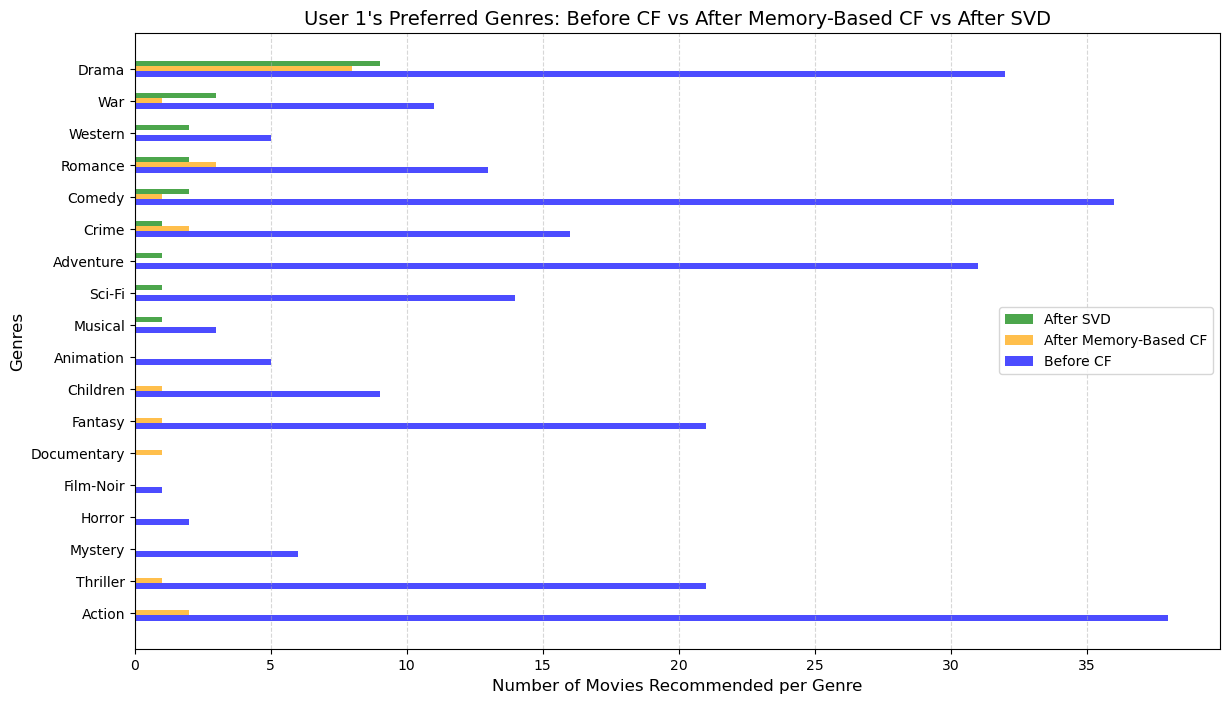

In [119]:
# Ensure the dataset is correctly merged
movies_data = pd.read_csv("movies.csv")
movies = df1[['movieId', 'title']].drop_duplicates()
movies = movies.merge(movies_data[['movieId', 'genres']], on='movieId', how='left')

# Extract genres before CF (highly rated movies by user 1)
before_genres = user_1_data_sorted[user_1_data_sorted["rating"] >= 4.0]["genres"].str.split("|").explode()
before_genre_counts = before_genres.value_counts()

# Extract genres after applying Memory-Based CF (user-based recommendations)
cf_genres = user_based_recommendations["genres"].str.split("|").explode()
cf_genre_counts = cf_genres.value_counts()

# Extract genres after applying SVD (user-based recommendations from SVD)
svd_movie_ids = [pred[0] for pred in predict_missing_ratings(example_user, num=10)]
svd_movies = movies[movies["movieId"].isin(svd_movie_ids)]
svd_genres = svd_movies["genres"].str.split("|").explode()
svd_genre_counts = svd_genres.value_counts()

# Merge genre distributions
genre_comparison_df = pd.DataFrame({
    "Genre": before_genre_counts.index.union(cf_genre_counts.index).union(svd_genre_counts.index),
    "Before CF": before_genre_counts,
    "After Memory-Based CF": cf_genre_counts,
    "After SVD": svd_genre_counts
}).fillna(0)

# Convert counts to integers
genre_comparison_df["Before CF"] = genre_comparison_df["Before CF"].astype(int)
genre_comparison_df["After Memory-Based CF"] = genre_comparison_df["After Memory-Based CF"].astype(int)
genre_comparison_df["After SVD"] = genre_comparison_df["After SVD"].astype(int)

# Sort genres by "After SVD" count for better visualization
genre_comparison_df = genre_comparison_df.sort_values(by="After SVD", ascending=True)

# Plot bar chart with **wider spacing**
plt.figure(figsize=(14, 8))
bar_width = 0.25  # **Narrower bars for better spacing**
index = np.arange(len(genre_comparison_df)) * 1.5  # **Increase gap between bars**

plt.barh(index + 2 * bar_width, genre_comparison_df["After SVD"], bar_width, label="After SVD", alpha=0.7, color="green")
plt.barh(index + bar_width, genre_comparison_df["After Memory-Based CF"], bar_width, label="After Memory-Based CF", alpha=0.7, color="orange")
plt.barh(index, genre_comparison_df["Before CF"], bar_width, label="Before CF", alpha=0.7, color="blue")

# Labels and Titles
plt.xlabel("Number of Movies Recommended per Genre", fontsize=12)
plt.ylabel("Genres", fontsize=12)
plt.title("User 1's Preferred Genres: Before CF vs After Memory-Based CF vs After SVD", fontsize=14)
plt.yticks(index + bar_width, genre_comparison_df["Genre"])  # **Align genre labels with new spacing**
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Show plot
plt.show()


### Summary
##### Comparison of SVD & Memory-Based CF

**The goal of user-based collaborative filtering is to enhance the recommendation accuracy.**

| Aspect                     | Memory-Based CF                                     | SVD (Model-Based CF)                           |
|----------------------------|----------------------------------------------------|-----------------------------------------------|
| **Learning Approach**      | Finds similar users/items and recommends based on explicit rating similarities | Learns latent factors from all users and items |
| **Data Dependence**        | Requires explicit ratings and direct similarities  | Learns implicit preferences from **all users** |
| **Recommendation Scope**   | Limited to direct neighbors (users/movies with high similarity) | Can recommend movies with **no direct rating similarity** but similar latent characteristics |
| **Performance on Sparse Data** | Struggles when user-item interactions are sparse | Performs well, as it generalizes from all users |


# Content-based Filtering (CBF)
- Part 1: Data Merging Process for CBF
- Part 2: Supervised learning
- Part 3: Unsupervised learning

## Part 1: Data Merging Process for CBF

In [94]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [95]:
tmovies_df=pd.read_csv('tmdb_5000_movies.csv')
credits_df=pd.read_csv('tmdb_5000_credits.csv')
movies_df=pd.read_csv('movies.csv')

C:\Users\aliso\AppData\Local\Temp\ipykernel_17548\2075304888.py:2: DtypeWarning: Columns (0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,25

In [96]:
tmovies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [97]:
tmovies_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",12/10/09,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",5/19/07,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",10/26/15,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",7/16/12,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",3/7/12,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [98]:
def extract_names(data):
    try:
        data_list = json.loads(data)
        names = [person['name'] for person in data_list if 'name' in person]
        return ', '.join(names)
    except (json.JSONDecodeError, TypeError):
        return None  

tmovies_df['genres'] = tmovies_df['genres'].apply(extract_names)
tmovies_df['keywords'] = tmovies_df['keywords'].apply(extract_names)
tmovies_df['production_companies'] = tmovies_df['production_companies'].apply(extract_names)
tmovies_df['production_countries'] = tmovies_df['production_countries'].apply(extract_names)
tmovies_df['spoken_languages'] = tmovies_df['spoken_languages'].apply(extract_names)

# columns 'homepage' has little meaning, so drop it. columns 'original tile' and 'title' express almost the same meaning, so drop 'original title'
tmovies_df=tmovies_df.drop(['homepage','original_title'],axis=1)
tmovies_df.head()

,budget,genres,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"Action, Adventure, Fantasy, Science Fiction",19995,"culture clash, future, space war, space colony...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",12/10/09,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"Adventure, Fantasy, Action",285,"ocean, drug abuse, exotic island, east india t...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,5/19/07,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"Action, Adventure, Crime",206647,"spy, based on novel, secret agent, sequel, mi6...",en,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",10/26/15,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"Action, Crime, Drama, Thriller",49026,"dc comics, crime fighter, terrorist, secret id...",en,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",United States of America,7/16/12,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"Action, Adventure, Science Fiction",49529,"based on novel, mars, medallion, space travel,...",en,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,United States of America,3/7/12,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [99]:
credits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4813 entries, 0 to 4812
Columns: 1265 entries, movie_id to Unnamed: 1264
dtypes: object(1265)
memory usage: 46.5+ MB


In [100]:
credits_df.head()

,movie_id,title,cast,crew,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 1255,Unnamed: 1256,Unnamed: 1257,Unnamed: 1258,Unnamed: 1259,Unnamed: 1260,Unnamed: 1261,Unnamed: 1262,Unnamed: 1263,Unnamed: 1264
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# credits file contains two special columns which are cast and crew, they occupy too many columns
# treat with these two columns and leave only name info
def extract_names(data):
    try:
        data_list = json.loads(data)
        names = [person['name'] for person in data_list if 'name' in person]
        return ', '.join(names)
    except (json.JSONDecodeError, TypeError):
        return None  

credits_df['cast_names'] = credits_df['cast'].apply(extract_names)
credits_df['crew_names'] = credits_df['crew'].apply(extract_names)

credits_df = credits_df[['movie_id', 'title', 'cast_names', 'crew_names']]

credits_df.head()

,movie_id,title,cast_names,crew_names
0,19995,Avatar,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Stephen E. Rivkin, Rick Carter, Christopher Bo..."
1,285,Pirates of the Caribbean: At World's End,"Johnny Depp, Orlando Bloom, Keira Knightley, S...","Dariusz Wolski, Gore Verbinski, Jerry Bruckhei..."
2,206647,Spectre,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra...","Thomas Newman, Sam Mendes, Anna Pinnock, John ..."
3,49026,The Dark Knight Rises,"Christian Bale, Michael Caine, Gary Oldman, An...","Hans Zimmer, Charles Roven, Christopher Nolan,..."
4,49529,John Carter,"Taylor Kitsch, Lynn Collins, Samantha Morton, ...","Andrew Stanton, Andrew Stanton, John Lasseter,..."


In [102]:
credits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4813 entries, 0 to 4812
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   movie_id    4812 non-null   object
 1   title       4813 non-null   object
 2   cast_names  4799 non-null   object
 3   crew_names  4793 non-null   object
dtypes: object(4)
memory usage: 150.5+ KB


In [103]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [104]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [105]:
movies_df["title"] = movies_df["title"].str.replace(r"\s*\(\d{4}\)", "", regex=True)

In [106]:
# merge 'tmdb_5000_movies.csv','tmdb_5000_credits.csv' and 'movies.csv'
merged_df = pd.merge(tmovies_df, credits_df,on=['title'], how='inner')
merged_df = pd.merge(merged_df, movies_df,on=['title'], how='inner')
merged_df_mask = merged_df[['title', 'genres_y', 'movieId']]
ratings_df = pd.read_csv('ratings.csv')
ratings = pd.merge(merged_df_mask, ratings_df, on = ['movieId'], how = 'inner')
# ratings.to_csv("merged_ratings.csv")

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2790 entries, 0 to 2789
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                2790 non-null   int64  
 1   genres_x              2790 non-null   object 
 2   id                    2790 non-null   int64  
 3   keywords              2790 non-null   object 
 4   original_language     2790 non-null   object 
 5   overview              2790 non-null   object 
 6   popularity            2790 non-null   float64
 7   production_companies  2790 non-null   object 
 8   production_countries  2790 non-null   object 
 9   release_date          2790 non-null   object 
 10  revenue               2790 non-null   int64  
 11  runtime               2790 non-null   float64
 12  spoken_languages      2790 non-null   object 
 13  status                2790 non-null   object 
 14  tagline               2523 non-null   object 
 15  title                

In [14]:
# combine 'genres_x' and 'genres_y'
merged_df["genres"] = merged_df["genres_x"].fillna('') + "|" + merged_df["genres_y"].fillna('')
def clean_genres(genres):
    if isinstance(genres, str):
        unique_genres = set(genres.replace(",", "|").split("|")) 
        return ",".join(sorted(unique_genres))  
    return ""

merged_df["genres"] = merged_df["genres"].apply(clean_genres) 

# combine 'original_language' and 'spoken_languages'
merged_df["language"] = merged_df["original_language"].fillna('') + "|" + merged_df["spoken_languages"].fillna('')
merged_df["language"] = merged_df["language"].apply(lambda x: "|".join([lang for lang in x.split("|") if lang != "en"]) if isinstance(x, str) else x)
merged_df["language"] = merged_df["language"].str.strip("|")
merged_df["language"] = merged_df["language"].str.strip("|") 

# delete the redunt columns
merged_df.drop(columns=["genres_x","genres_y", "original_language", "spoken_languages", "movieId","id"], inplace=True)

# delete duplicated lines
merged_df = merged_df.drop_duplicates(subset=['title'], keep='first')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2648 entries, 0 to 2789
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                2648 non-null   int64  
 1   keywords              2648 non-null   object 
 2   overview              2648 non-null   object 
 3   popularity            2648 non-null   float64
 4   production_companies  2648 non-null   object 
 5   production_countries  2648 non-null   object 
 6   release_date          2648 non-null   object 
 7   revenue               2648 non-null   int64  
 8   runtime               2648 non-null   float64
 9   status                2648 non-null   object 
 10  tagline               2394 non-null   object 
 11  title                 2648 non-null   object 
 12  vote_average          2648 non-null   float64
 13  vote_count            2648 non-null   int64  
 14  movie_id              2648 non-null   object 
 15  cast_names            2645

In [15]:
merged_df.head()

,budget,keywords,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,movie_id,cast_names,crew_names,genres,language
0,237000000,"culture clash, future, space war, space colony...","In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",12/10/09,2787965087,162.0,Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Stephen E. Rivkin, Rick Carter, Christopher Bo...","Adventure, Fantasy, Science Fiction,Action,Ad...","English, Español"
1,300000000,"ocean, drug abuse, exotic island, east india t...","Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,5/19/07,961000000,169.0,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S...","Dariusz Wolski, Gore Verbinski, Jerry Bruckhei...","Action, Fantasy,Action,Adventure,Comedy,Fantasy",English
2,245000000,"spy, based on novel, secret agent, sequel, mi6...",A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",10/26/15,880674609,148.0,Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra...","Thomas Newman, Sam Mendes, Anna Pinnock, John ...","Adventure, Crime,Action,Adventure,Crime","Français, English, Español, Italiano, Deutsch"
3,260000000,"based on novel, mars, medallion, space travel,...","John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,United States of America,3/7/12,284139100,132.0,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ...","Andrew Stanton, Andrew Stanton, John Lasseter,...","Adventure, Science Fiction,Action,Adventure,I...",English
4,258000000,"dual identity, amnesia, sandstorm, love of one...",The seemingly invincible Spider-Man goes up ag...,115.699814,"Columbia Pictures, Laura Ziskin Productions, M...",United States of America,5/1/07,890871626,139.0,Released,The battle within.,Spider-Man 3,5.9,3576,559,"Tobey Maguire, Kirsten Dunst, James Franco, Th...","Francine Maisler, Joseph M. Caracciolo Jr., Sa...","Action, Adventure,Action,Adventure,Fantasy,IM...","English, Français"


In [16]:
merged_df.to_csv('merged_movie.csv',index=False)

In [17]:
movies=pd.read_csv('merged_movie.csv')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2648 entries, 0 to 2647
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                2648 non-null   int64  
 1   keywords              2546 non-null   object 
 2   overview              2648 non-null   object 
 3   popularity            2648 non-null   float64
 4   production_companies  2588 non-null   object 
 5   production_countries  2624 non-null   object 
 6   release_date          2648 non-null   object 
 7   revenue               2648 non-null   int64  
 8   runtime               2648 non-null   float64
 9   status                2648 non-null   object 
 10  tagline               2394 non-null   object 
 11  title                 2648 non-null   object 
 12  vote_average          2648 non-null   float64
 13  vote_count            2648 non-null   int64  
 14  movie_id              2648 non-null   float64
 15  cast_names           

## Part 2: Supervised-learning recommendation

### use different models to check the data of  'vote average' is true or not, then recommendate high 'vote average' movies

In [18]:
data = movies

In [19]:
data['text'] = (
    data['genres'].fillna('') + ' ' +
    data['keywords'].fillna('') + ' ' +
    data['cast_names'].fillna('').str.replace(',', ' ') + ' ' +
    data['crew_names'].fillna('').str.replace(',', ' ')
)
data['release_year'] = pd.to_datetime(data['release_date'], format='%m/%d/%y', errors='coerce').dt.year
x = data[['text', 'language', 'budget', 'runtime', 'popularity', 'release_year']]
y = data['vote_average']

In [20]:
# data preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, stop_words='english'), 'text'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['language']),
        ('num', StandardScaler(), ['budget', 'runtime', 'popularity', 'release_year'])
    ])

### use linear regression

In [21]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)

In [24]:
sample_movie = x_test.iloc[0:1]
sample_index = sample_movie.index[0]
predicted_rating = pipeline.predict(sample_movie)[0]
actual_rating = y_test.loc[sample_index]

print(f"\nPredicted rating for '{data.loc[sample_index, 'title']}': {predicted_rating:.2f}")
print(f"Actual rating: {actual_rating:.2f}")
print(f"Difference: {abs(predicted_rating - actual_rating):.2f}")


Predicted rating for 'End of Watch': 7.32
Actual rating: 7.20
Difference: 0.12


In [25]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (Linear Regression): {mse}")

Mean Squared Error (Linear Regression): 0.6503718206749078


### use random forest

In [26]:
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regress', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_rf.fit(x_train, y_train)
y_pred_rf = pipeline_rf.predict(x_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)

In [27]:
sample_movie = x_test.iloc[0:1]
sample_index = sample_movie.index[0]
predicted_rating_rf = pipeline_rf.predict(sample_movie)[0]
actual_rating = y_test.loc[sample_index]

print(f"\nPredicted rating for '{data.loc[sample_index, 'title']}': {predicted_rating_rf:.2f}")
print(f"Actual rating: {actual_rating:.2f}")
print(f"Difference: {abs(predicted_rating_rf - actual_rating):.2f}")


Predicted rating for 'End of Watch': 7.02
Actual rating: 7.20
Difference: 0.18


In [28]:
print("\nRandom Forest Regression Metrics:")
print(f"MSE: {mse_rf:.4f}")


Random Forest Regression Metrics:
MSE: 0.3990


### use Gradient Boosting Regression

In [29]:
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('regress', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

pipeline_gb.fit(x_train, y_train)
y_pred_gb = pipeline_gb.predict(x_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)

In [30]:
sample_movie = x_test.iloc[0:1]
sample_index = sample_movie.index[0]
predicted_rating_gb = pipeline_gb.predict(sample_movie)[0]
actual_rating = y_test.loc[sample_index]

print(f"\nPredicted rating for '{data.loc[sample_index, 'title']}': {predicted_rating_gb:.2f}")
print(f"Actual rating: {actual_rating:.2f}")
print(f"Difference: {abs(predicted_rating_gb - actual_rating):.2f}")


Predicted rating for 'End of Watch': 7.21
Actual rating: 7.20
Difference: 0.01


In [31]:
print("\nGradient Boosting Regression Metrics:")
print(f"MSE: {mse_gb:.4f}")


Gradient Boosting Regression Metrics:
MSE: 0.3873


### establish user_likes content to recommend

In [32]:
# establish a new column, if a user likes action or adventure movies, and the vote_average is higher than 7, then user likes it.
data['user_likes'] = ((data['genres'].str.contains('Action|Adventure', na=False)) & (data['vote_average'] > 7)).astype(int)
y_user = data['user_likes']
x_train_user, x_test_user, y_train_user, y_test_user = train_test_split(x, y_user, test_size=0.2, random_state=42)


pipeline_user = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline_user.fit(x_train_user, y_train_user)
like_probabilities = pipeline_user.predict_proba(x)[:, 1]
recommendations = data.iloc[like_probabilities.argsort()[::-1][:5]]['title'].tolist()
print(like_probabilities)
print("Top 5 Recommended Movies for User (Action/Adventure):", recommendations)

[0.68 0.01 0.09 ... 0.   0.01 0.05]
Top 5 Recommended Movies for User (Action/Adventure): ['Back to the Future Part III', 'Monsters, Inc.', 'Harry Potter and the Half-Blood Prince', 'Harry Potter and the Goblet of Fire', 'Harry Potter and the Order of the Phoenix']


## Part 3: Unsupervised-learning recommendation

In [34]:
# content-based recommendation
# step 1: select 'genre','keywords' to combine as a feature. 
# users can choose the features they are interested in.
movies['combined_features'] = (
    movies['genres'].fillna('') + ' ' + 
    movies['keywords'].fillna('')
     
)
# step 2: calculate the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['combined_features'])

# step 3: calculate the similarity of cosine
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# step 4: recommendation based on the movie title
def recommend_movies(movie_title, num_recommendations):
    # get the target movie index. Here it locates the first movie.
    movie_idx = movies[movies['title'] == movie_title].index[0]
    
    #  get the similarity score with this movie
    sim_scores = list(enumerate(cosine_sim[movie_idx]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # recommendate similar movies
    sim_scores = sim_scores[1:num_recommendations + 1]
    movie_indices = [idx for idx, score in sim_scores]
    suggest_idx = [score[0] for score in sim_scores]
    suggest_score = [score[1] for score in sim_scores]
    recommend_movies = movies.iloc[suggest_idx]['title']
    return pd.DataFrame({'Title': recommend_movies, 'Similarity Score': suggest_score})

# sample
recommendations = recommend_movies('Avatar', 5)
recommendations

,Title,Similarity Score
37,Star Trek Into Darkness,0.464724
190,Gravity,0.451964
218,Planet of the Apes,0.448466
407,Soldier,0.446567
1603,Aliens,0.440551


In [35]:
# KNN recommendation

# step 1: select features
movie_features = movies[['vote_average', 'vote_count', 'popularity']].fillna(0)

# step 2: standardize the feature
scaler = StandardScaler()
scaled_features = scaler.fit_transform(movie_features)

# step 3: use cosine value to define the neighbours
knn = NearestNeighbors(metric='euclidean', algorithm='brute')
knn.fit(scaled_features)

# step 4 : define the function
def knn_recommend(movie_title, n_neighbors=5):
    movie_idx = movies[movies['title'] == movie_title].index[0]
    distances, indices = knn.kneighbors([scaled_features[movie_idx]], n_neighbors=n_neighbors + 1)
    recommended_movies = movies.iloc[indices[0][1:]][['title', 'vote_average', 'vote_count', 'popularity']]
    return recommended_movies

# sample
knn_recommend('Avatar', 5)


,title,vote_average,vote_count,popularity
78,Inception,8.1,13752,167.583710
501,Fight Club,8.3,9413,146.757391
225,Django Unchained,7.8,10099,82.121691
53,Iron Man,7.4,8776,120.725053
324,The Hunger Games,6.9,9455,68.550698


In [36]:
# score-genres based filter
# calculate the weighted score
m = movies['vote_count'].quantile(0.75)  # use the 0.75 quantile as the minimum
C = movies['vote_average'].mean()  

def weighted_rating(row, m=m, C=C):
    v = row['vote_count']
    R = row['vote_average']
    return (v / (v + m) * R) + (m / (v + m) * C)

movies['weighted_rating'] = movies.apply(weighted_rating, axis=1)


def get_score_based_recommendations(genre=None, data=movies, top_n=10):
    if genre:
        filtered_data = data[movies['genres'].str.contains(genre, case=False, na=False)]
    else:
        filtered_data = data
    top_movies = filtered_data.sort_values('weighted_rating', ascending=False).head(top_n)
    return top_movies[['title', 'vote_average', 'vote_count', 'weighted_rating']]

# sample
print("Top 10 Weighted_rating:")
print(get_score_based_recommendations())
print("\nTop 10 Action Movies:")
print(get_score_based_recommendations('Action'))

Top 10 Weighted_rating:
                        title  vote_average  vote_count  weighted_rating
501                Fight Club           8.3        9413         8.096091
2054             Pulp Fiction           8.3        8428         8.074926
609              Forrest Gump           8.2        7927         7.974196
78                  Inception           8.1       13752         7.970153
77               Interstellar           8.1       10867         7.938750
1281         Schindler's List           8.3        4329         7.903793
2346                 Whiplash           8.3        4254         7.898203
61                 Inside Out           8.0        6560         7.761565
1538       Back to the Future           8.0        6079         7.745505
76    Guardians of the Galaxy           7.9        9742         7.741619

Top 10 Action Movies:
                        title  vote_average  vote_count  weighted_rating
501                Fight Club           8.3        9413         8.096091
78  

In [37]:
# context and weighted-rating based recommendation
data=movies
def context_rating_recommend(user_language=None, user_country=None, runtime_range=None, release_year=None, data=data, top_n=5):
    filtered_data = data.copy()
    
    # based on language
    if user_language:
        filtered_data = filtered_data[filtered_data['language'].str.contains(user_language, na=False)]
    
    # based on production_countries
    if user_country:
        filtered_data = filtered_data[filtered_data['production_countries'].str.contains(user_country, na=False)]
    
    # based on run time
    if runtime_range:
        min_runtime, max_runtime = runtime_range
        filtered_data = filtered_data[(filtered_data['runtime'] >= min_runtime) & (filtered_data['runtime'] <= max_runtime)]
    
    # based on release year
    if release_year:
        filtered_data['release_year'] = pd.to_datetime(filtered_data['release_date'], format='%m/%d/%y', errors='coerce').dt.year
        filtered_data = filtered_data[filtered_data['release_year'] == release_year]
    
    # based on weighted_rating
    return filtered_data.sort_values(by='weighted_rating', ascending=False)['title'].head(top_n).tolist()


print("Context Recommendations (English, USA, 90-150 min, 2015):")
print(context_rating_recommend(
    user_language='English',
    user_country='United States of America',
    runtime_range=(90, 150),
    release_year=2015,
    data=movies
))

Context Recommendations (English, USA, 90-150 min, 2015):
['Inside Out', 'The Martian', 'Spotlight', 'Avengers: Age of Ultron', 'Mad Max: Fury Road']
